In [1]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import math
# from scipy.optimize import fsolve
# from scipy.optimize import root
from scipy.optimize import minimize
# from scipy import signal
from scipy import linalg
# import scipy as scp
# import sympy as  syp
# from tensorflow.keras import backend as K
# from tensorflow.keras.layers import Layer
# from tensorflow.keras.models import Sequential
import gc

In [2]:
class process_hyperspec(object):
    
    def __init__(self, path, scat):
        self.path = path
        self.scat = scat
        
    def read_data(self):
        ## Read data from txt
        data=pd.read_fwf(self.path, dtype = object, header = None)## Read data as Pandas DataFrame
        data_8 = data.loc[8,:].str[6:] ## Select data of column of wavelengths

        data_nm_dataframe =pd.read_csv(StringIO(data_8[0]))

        with open(self.path,'r',encoding='utf-8') as f:
            content = f.read()

        flag = 0
        for index in range(len(content)):##find the start point  of time and intensity data, pointer is the 'index'
            if (content[index] == '\n') and (flag != 9):
                flag = flag + 1
            elif (content[index] == '\n') and (flag == 9):
                break
            else:
                continue

        data_ns = pd.read_csv(StringIO(content[index:len(content)]), names = data_nm_dataframe.columns[0:len(set(data_nm_dataframe))]) ## Read data of time and gray 
        img_nm_ns = np.array(data_ns)    ## Transform to numpy array                                image as DataFrame; names is a 640x0 array indicates the wavelengths range
        
        self.data_frame = data_ns
        self.data_array = img_nm_ns
        
    def cal_846nm(self):
        time_total, wavelength_total = self.data_array.shape ## Generate an array contains intensity versus time data on 846nm
        data_846nm = np.zeros((time_total,), dtype = float )
        for i in range(wavelength_total):
            data_846nm = self.data_array[:,i] + data_846nm

        return data_846nm/wavelength_total
    
    def return_dataframe(self):
        
        return self.data_frame
    
    def return_array(self):
        return self.data_array

In [3]:
def name_g(i):
    if(i<=4 and i>=0):
        return  '0'+str(2*i+1)
    elif(i>4):
        return str(2*i+1)
    else:
        return None
    

dict1 = {i:'t5ns_scat'+ name_g(i) +'_abs_00.txt' for i in range(0, 8)}
dict1[-1] = 'ref_real_5ns.txt'


# print(dict1)

scat = [None]*9
data_480multi9 = np.zeros((9,480), dtype = float)
for i in range(0,9):
    scat[i] = process_hyperspec(dict1[i-1], i)
    scat[i].read_data()
    data_480multi9[i,:] = scat[i].cal_846nm()

time_index = scat[0].return_dataframe().index
# plt.figure('ns/nm')
# for i in range(0,9):
#     plt.plot(data_480multi9[i,:])
    
# plt.show()
del scat, dict1, name_g, process_hyperspec
gc.collect()

10

In [4]:
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth



def split_signal(y):
    THRESHOLD_V = 0.02
    for i in range(len(y)):
        if y[i] > THRESHOLD_V and y[i-1] <= THRESHOLD_V:
            index1  = i
        elif y[i] < THRESHOLD_V and y[i-1] >= THRESHOLD_V:
            index2 = i
    y2 = np.zeros((index2 - index1 + 1,))
    y2 = y[index1:index2]
        
    return y2, index1

#Generate h,y(x*h = y)
#===================================================================================================
data_intensity_extended = np.zeros((9, 959), dtype = float)
data_intensity_extended[:, 0:479]  = data_480multi9[:,0:479]
MAX = np.max(data_480multi9)
# h = smooth(data_480multi9[0,:]/max(data_480multi9[0,:]), 10) #x*h = y ; x.shape = (480,) h.shape = (480,) y.shape = (959,)
h = smooth(data_480multi9[0,:]/MAX, 10)

y =np.zeros((9,959))
for i in range(0,9):
    y[i,:] = smooth(data_intensity_extended[i,:]/MAX, 10)
    
#======================================================================================================

In [7]:
#Define model
#=============================================================================================================
class MyConv1d(tf.keras.layers.Layer):
    def __init__(self):
        super(MyConv1d, self).__init__()
    
    def build(self, input_shape):
        # self.x = self.add_weight("kernel", shape=[1, int(input_shape[-1])*3 - 2, 1])
        # self.x = self.add_weight("kernel1", shape=[int(input_shape[0]), ], dtype = float, initializer = tf.zeros_initializer()
        #                         , trainable = True)
        # init = tf.constant_initializer(x_)
        self.x = self.add_weight("kernel1", shape=[int(input_shape[0]), ], dtype = float, initializer = tf.random_normal_initializer()
                                , trainable = True)
        
    def call(self, h):
        # y = tf.convert_to_tensor(np.convolve(x, h)) 
        x = tf.concat([tf.zeros((len(h) - 1,), dtype =  float), self.x, tf.zeros((len(h) - 1,), dtype =  float)], axis =  0)
        x = tf.reshape(x, [1, -1, 1])
        h = tf.reshape(h, [len(h), 1, 1])
        y = tf.nn.conv1d(x, h[::-1], [1], padding = 'VALID', data_format='NWC', dilations=None, name=None) # h[::-1] means reverse h along time axis
        return y

class bias_add(tf.keras.layers.Layer):
    def __init__(self):
        super(bias_add, self).__init__()
    
    def build(self, input_shape):
        # self.x = self.add_weight("kernel", shape=[1, int(input_shape[-1])*3 - 2, 1])
        self.bias = self.add_weight("kernel0", shape=[int(input_shape[0]), ], dtype = float, initializer = tf.zeros_initializer()
                                   , trainable = True)

    def call(self, h):
        y = tf.add(h, self.bias)
        return y, self.bias
    
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.add_bias = bias_add()
        self.conv1d = MyConv1d()
        
    def call(self, input_tensor):
        # input_tensor = tf.reshape(input_tensor, [-1,1])
        y,  bias = self.add_bias(input_tensor, training = True)
        y = self.conv1d(y, training = True)

        return y, bias
    
    
def loss(model, x, y):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
    y_, bias = model(x)
    
    
    return tf.math.reduce_mean(tf.math.square(y-y_)) + tf.math.reduce_mean(tf.math.square(bias))
    # return tf.math.reduce_mean(tf.math.square(y-y_)) 


def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)
#===============================================================================================

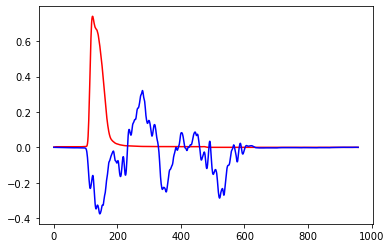

TensorShape([1, 959, 1])

In [9]:
#Test model forward propagation
#=======================================================================
model = MyModel()
predictions, bias = model(h)
plt.figure()
plt.plot(y[1,:], color = 'red')
plt.plot(predictions[0,:,0], color = 'blue')
plt.show()
predictions.shape
#=======================================================================

In [10]:
#Test loss, grads calculation
#===================================================================
l = loss(model, h, y[i,:])
print("Loss test: {}".format(l))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_value, grads = grad(model, h, y[i,:])

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, h, y[i,:]).numpy()))
#=========================================================================

#Examine model structure/trainable variables
#========================================================================
print([var.name for var in model.trainable_variables])
model.summary()
#=========================================================================








Loss test: 0.013353870250284672
Step: 0, Initial Loss: 0.013353870250284672
Step: 1,         Loss: 0.013215390965342522
['my_model_2/bias_add_2/kernel0:0', 'my_model_2/my_conv1d_2/kernel1:0']
Model: "my_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bias_add_2 (bias_add)        multiple                  480       
_________________________________________________________________
my_conv1d_2 (MyConv1d)       multiple                  480       
Total params: 960
Trainable params: 960
Non-trainable params: 0
_________________________________________________________________


In [11]:
#Train 2000 epochs
#================================================================================
num_epochs = 200
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
for epoch in range(num_epochs):
    # epoch_loss_avg = tf.keras.metrics.Mean()

  # Training loop - using batches of 32
    # Optimize the model
    loss_value, grads = grad(model, h, y[i,:])
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 20 == 0:
        print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, h, y[i,:]).numpy()))
#===============================================================================













Step: 1,         Loss: 0.0055131190456449986
Step: 21,         Loss: 0.0010008066892623901
Step: 41,         Loss: 0.0002006434660870582
Step: 61,         Loss: 0.0001015961097436957
Step: 81,         Loss: 8.633539982838556e-05
Step: 101,         Loss: 8.205658377846703e-05
Step: 121,         Loss: 8.074323704931885e-05
Step: 141,         Loss: 8.005569543456659e-05
Step: 161,         Loss: 7.964998803799972e-05
Step: 181,         Loss: 7.936394831631333e-05


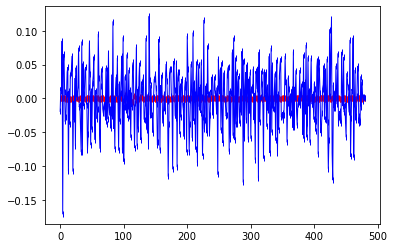

In [12]:
plt.figure(num = 'weights')
plt.plot(model.trainable_variables[0][:], linewidth = '1', label = "bias", color='red', linestyle='--', marker='|')
plt.plot(model.trainable_variables[1][:], linewidth = '1', label = "kernel", color='blue', linestyle='-', marker='|')
plt.show()
# model.trainable_variables


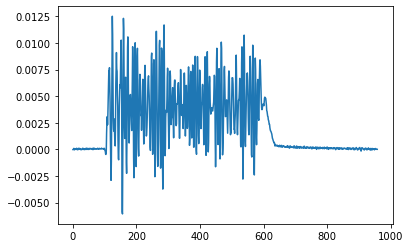

In [13]:
plt.plot(np.convolve(model.trainable_variables[1],h))
plt.show()